In [12]:
# Import the modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.delaunay as triang
import matplotlib.mlab as mlab
import matplotlib.cm as cm
from scipy.interpolate import griddata
from scipy import stats
import datetime
from time import strftime
%matplotlib inline

In [36]:
# Import the provided data
dcminutedata = np.genfromtxt('MinuteData/DeepCoveNew.txt')[:,1]
jbminutedata = np.genfromtxt('MinuteData/JamesBayNew.txt')[:,1]
jmminutedata = np.genfromtxt('MinuteData/JohnMuirNew.txt')[:,1]
uvminutedata = np.genfromtxt('MinuteData/UVicISCNew.txt')[:,1]
hourdata = np.genfromtxt('AllHourly/AllHourly.txt')[:,2:]
coastdata = np.genfromtxt('Coast.txt')

In [3]:
# Import the school data
schoollongs = np.genfromtxt('AllHourly/AllHourly.txt')[:,0]
schoollats = np.genfromtxt('AllHourly/AllHourly.txt')[:,1]

# Test
print schoollongs
print schoollats
lines = len(coastdata)
coastlongs = [lon+360. for lon in coastdata[:lines/2]] 
coastlats = coastdata[lines/2:]

[ 236.547  236.655  236.499  236.514  236.63   236.523  236.543  236.558
  236.604  236.43   236.7    236.693  236.471  236.446  236.62   236.283
  236.597  236.635  236.595  236.67   236.504  236.686  236.6    236.661
  236.567  236.639  236.376  236.596  236.652  236.672  236.607  236.676
  236.681  236.653  236.451]
[ 48.5697  48.4697  48.5376  48.4356  48.5273  48.4529  48.6804  48.4663
  48.4382  48.66    48.4651  48.4289  48.4281  48.364   48.4169  48.3874
  48.5677  48.4788  48.4253  48.4161  48.4661  48.4182  48.4806  48.4408
  48.5234  48.4456  48.6538  48.6529  48.4153  48.4275  48.4519  48.4865
  48.4699  48.4293  48.4572]


In [4]:
# Create a time array for the hour data
def createHourArray(hourdata):
    hours = []
    current = datetime.datetime(2009,1,1)  # The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333
    print type(current)
    
    for i in range(len(hourdata[0])):
        hours.append(current.isoformat(' '))
        current += datetime.timedelta(hours=1)
        
    return hours   

def createMinuteArray(minutedata):
    minutes = []
    current = datetime.datetime(2009,1,1)  # The data sets start on 1 Jan 2009 a minute after midnight local, or at 08:00 UTC = 733408.333
    
    for i in range(len(minutedata)):
        minutes.append(current.isoformat(' '))
        current += datetime.timedelta(minutes=1)
        
    return minutes
    
hours_as_strings = createHourArray(hourdata)
minutes_as_strings = createMinuteArray(dcminutedata)

# print for testing
print 'HOURS:'
for i in range(10):
    print hours_as_strings[i]    

print 'MINUTES:'
for i in range(10):
    print minutes_as_strings[i]

<type 'datetime.datetime'>
HOURS:
2009-01-01 00:00:00
2009-01-01 01:00:00
2009-01-01 02:00:00
2009-01-01 03:00:00
2009-01-01 04:00:00
2009-01-01 05:00:00
2009-01-01 06:00:00
2009-01-01 07:00:00
2009-01-01 08:00:00
2009-01-01 09:00:00
MINUTES:
2009-01-01 00:00:00
2009-01-01 00:01:00
2009-01-01 00:02:00
2009-01-01 00:03:00
2009-01-01 00:04:00
2009-01-01 00:05:00
2009-01-01 00:06:00
2009-01-01 00:07:00
2009-01-01 00:08:00
2009-01-01 00:09:00


In [38]:
# Fix the NANs! (hour data)
def fixnans_hours(data):
    # Find the nans
    points = np.where(np.isnan(data))
    print points
    
    # Find the known values
    #values = data[~np.isnan(data)]
    
    # Interpolate by space to start
    data = data.T
    for hour in data:
        nans = np.isnan(hour)
        #hour[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), hour[~nans])  
        hour[nans] = np.nanmean(hour)
        
    # Find the nans
    points = np.where(np.isnan(data))
    print points
        
    # Interpolate by time with remaining nans
    data = data.T
    for station in data:
        nans = np.isnan(station)
        station[nans] = np.interp(np.flatnonzero(nans), np.flatnonzero(~nans), station[~nans])
    #data.transpose()
    
    # Find the nans
    points = np.where(np.isnan(data))
    print points
    
    
    # Replace nans with station averages at that time if at least one station is working
    #np.transpose(data)
    #for i,hour in enumerate(data):
    #    if hasattr(data[i], '__len__'):
    #        for j,station in enumerate(data[i]):
    #            if np.isnan(station):
    #                data[i][j] = np.nanmean(data[i])
    #np.transpose(data)

    # Interpolate the remaining nans in hour data
    #for i in range(len(data)):
    #    ok = -np.isnan(data[i])
    #    xp = ok.ravel().nonzero()[0]
    #    fp = data[i][-np.isnan(data[i])]
    #    x  = np.isnan(data[i]).ravel().nonzero()[0]

    #    data[i][np.isnan(data[i])] = np.interp(x, xp, fp)
    
    print 'done'
    return data[:]


# Fix the NANs! (minute data)
def fixnans_minutes(data):
    ok = -np.isnan(data)
    xp = ok.ravel().nonzero()[0]
    fp = data[-np.isnan(data)]
    x  = np.isnan(data).ravel().nonzero()[0]

    data[np.isnan(data)] = np.interp(x, xp, fp)    
    
    return data[:]
    

hourdata = fixnans_hours(hourdata[:])

#dcminutedata = fixnans_minutes(dcminutedata[:])
#jbminutedata = fixnans_minutes(jbminutedata[:])
#jmminutedata = fixnans_minutes(jmminutedata[:])
#uvminutedata = fixnans_minutes(uvminutedata[:])

#while i < len(dcminutedata):
#    for j in range(10):
#        print dcminutedata[i]
        

(array([ 0,  0,  0, ..., 34, 34, 34], dtype=int64), array([    0,     1,     2, ..., 25432, 25433, 25434], dtype=int64))
(array([    0,     0,     0, ..., 17493, 17493, 17493], dtype=int64), array([ 0,  1,  2, ..., 32, 33, 34], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
done


C:\Anaconda\lib\site-packages\numpy\lib\nanfunctions.py:598: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


<module 'matplotlib.pyplot' from 'C:\Anaconda\lib\site-packages\matplotlib\pyplot.pyc'>

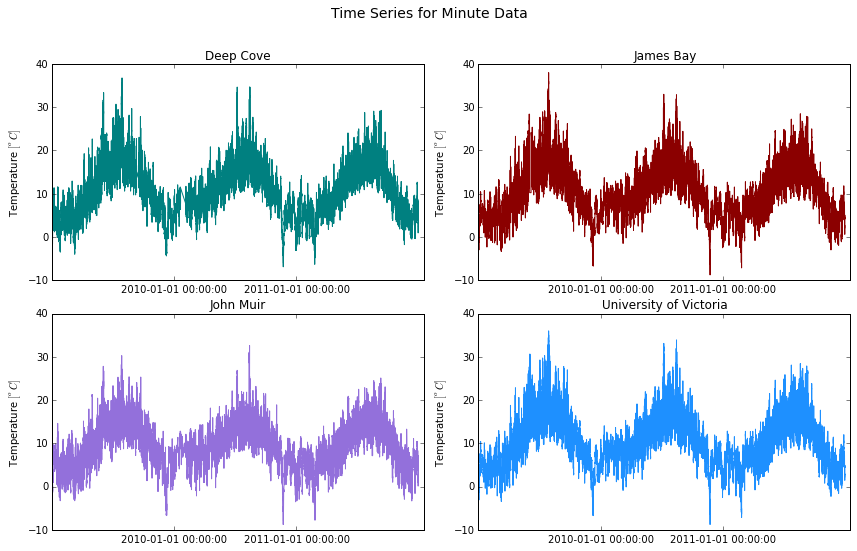

In [70]:
# Plot the minute time series
def plotTimeSeries(labels):
    plt.figure(figsize=(12,8))        # Make figure
    gs=gridspec.GridSpec(2,2)         # Set up the layout
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])
    
    x = np.arange(len(labels))
    
    # Plot the time series individually
    ax1.plot(x, dcminutedata, color='teal');    ax1.set_title('Deep Cove'); ax1.set_ylabel(r'Temperature $[^oC]$')
    ax2.plot(x, jbminutedata, color='darkred');  ax2.set_title('James Bay'); ax2.set_ylabel(r'Temperature $[^oC]$')
    ax3.plot(x, jmminutedata, color='mediumpurple'); ax3.set_title('John Muir'); ax3.set_ylabel(r'Temperature $[^oC]$')
    ax4.plot(x, uvminutedata, color='dodgerblue');   ax4.set_title('University of Victoria'); ax4.set_ylabel(r'Temperature $[^oC]$')
     
    one_year = 365*24*60    
        
    # Set the x label frequencies
    ax1.set_xticks( x[ one_year: :one_year ] )
    ax2.set_xticks( x[ one_year: :one_year ] )
    ax3.set_xticks( x[ one_year: :one_year ] )
    ax4.set_xticks( x[ one_year: :one_year ] )
    
    # Set the x label words
    ax1.set_xticklabels( labels[ one_year: :one_year ])
    ax2.set_xticklabels( labels[ one_year: :one_year ])
    ax3.set_xticklabels( labels[ one_year: :one_year ])
    ax4.set_xticklabels( labels[ one_year: :one_year ])
    
    # Give all plots the same scale
    ax1.set_ylim(bottom=-10,top=40)
    ax2.set_ylim(bottom=-10,top=40)
    ax3.set_ylim(bottom=-10,top=40)
    ax4.set_ylim(bottom=-10,top=40)
        
    title = plt.suptitle('Time Series for Minute Data', fontsize=14)
    plt.tight_layout()
    title.set_y(0.95)
    plt.subplots_adjust(top=0.85)
    return plt

plotTimeSeries(minutes_as_strings)


    

In [21]:
# Find the means and standard deviations at our four stations
def printStats(dc, jb, jm, uv):
    print 'Deep Cove Statistics:'
    print '\tMean:\t', np.mean(dc)
    print '\tVariance:\t', np.std(dc)
    print 'James Bay Statistics:'
    print '\tMean:\t', np.mean(jb)
    print '\tVariance:\t', np.std(jb)
    print 'John Muir Statistics:'
    print '\tMean:\t', np.mean(jm)
    print '\tVariance:\t', np.std(jm)
    print 'University of Victoria Statistics:'
    print '\tMean:\t', np.mean(uv)
    print '\tVariance:\t', np.std(uv)
    
printStats(dcminutedata, jbminutedata, jmminutedata, uvminutedata)

Deep Cove Statistics:
	Mean:	10.3016961717
	Variance:	5.98077841283
James Bay Statistics:
	Mean:	10.2421039853
	Variance:	5.74361183461
John Muir Statistics:
	Mean:	9.11952154098
	Variance:	4.83580245355
University of Victoria Statistics:
	Mean:	10.2363971533
	Variance:	5.69957429739


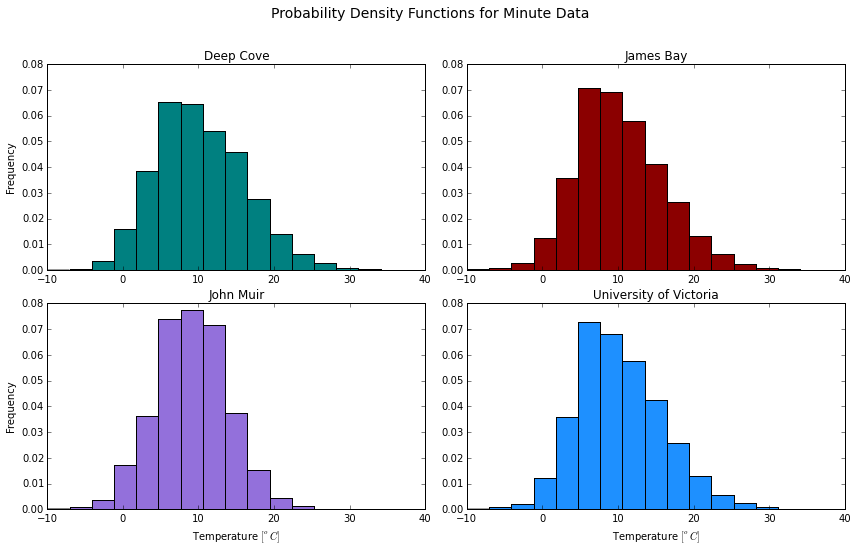

In [69]:
# Plot the temperature PDFs
def plotPDFs(dc, jb, jm, uv):
    plt.figure(figsize=(12,8))        # Make figure
    gs=gridspec.GridSpec(2,2)         # Set up the layout
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])
    
    bins =np.linspace(-10, 40, 18)
    
    # plot the PDFs individually
    ax1.hist(dc, bins = bins, normed=True, color='teal'); ax1.set_title('Deep Cove')
    ax2.hist(jb, bins = bins, normed=True, color='darkred'); ax2.set_title('James Bay')
    ax3.hist(jm, bins = bins, normed=True, color='mediumpurple'); ax3.set_title('John Muir')
    ax4.hist(uv, bins = bins, normed=True, color='dodgerblue'); ax4.set_title('University of Victoria')
    
    # Give all plots the same scale
    ax1.set_ylim(bottom=0,top=0.08)
    ax2.set_ylim(bottom=0,top=0.08)
    ax3.set_ylim(bottom=0,top=0.08)
    ax4.set_ylim(bottom=0,top=0.08)
    
    # Add the axes labels
    #ax1.set_xlabel('Temperature [deg C]'); 
    ax1.set_ylabel('Frequency')
    #ax2.set_xlabel('Temperature [deg C]'); ax2.set_ylabel('Frequency')
    ax3.set_xlabel(r'Temperature $[^oC]$'); ax3.set_ylabel('Frequency')
    ax4.set_xlabel(r'Temperature $[^oC]$'); #ax4.set_ylabel('Frequency')
    
    title = plt.suptitle('Probability Density Functions for Minute Data', fontsize=14)
    plt.tight_layout()
    title.set_y(0.95)
    plt.subplots_adjust(top=0.85)
    
plotPDFs(dcminutedata, jbminutedata, jmminutedata, uvminutedata)

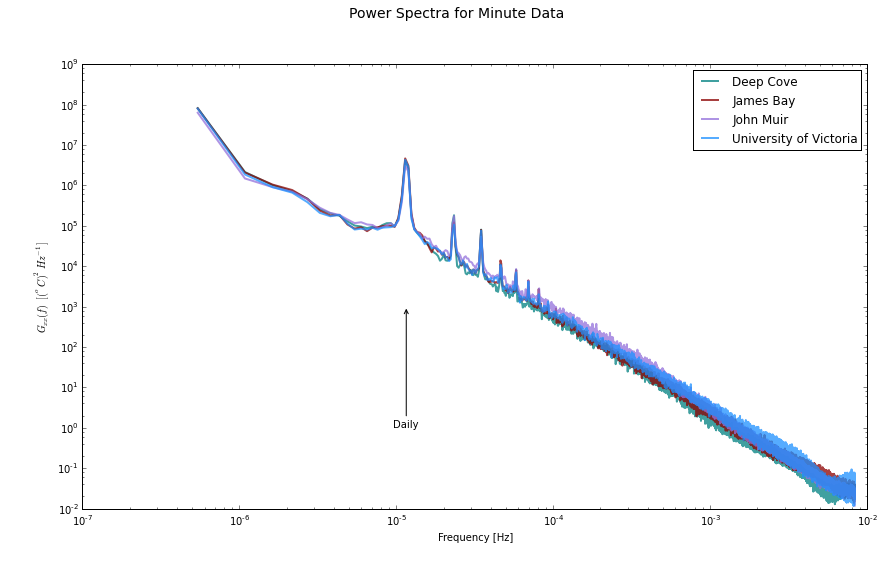

In [145]:
# Plot the power spectra
def plotPowerSpectra_minute(dc, jb, jm, uv):
    plt.figure(figsize=(12,8))        # Make figure
    gs=gridspec.GridSpec(1,1)         # Set up the layout
    ax = plt.subplot(gs[0])
    
    dt = 60.
    fs = 1./dt
    nfft = 1024*30
    #window = mlab.window_none
    window = mlab.window_hanning
    
    # Compute the power spectra
    pp_dc,f_dc=mlab.psd(dc,NFFT=nfft,window=window,Fs=fs)
    pp_jb,f_jb=mlab.psd(jb,NFFT=nfft,window=window,Fs=fs)
    pp_jm,f_jm=mlab.psd(jm,NFFT=nfft,window=window,Fs=fs)
    pp_uv,f_uv=mlab.psd(uv,NFFT=nfft,window=window,Fs=fs)
    
    # plot the power spectra together
    ax.loglog(f_dc,pp_dc,color='teal',label='Deep Cove',alpha=0.75,linewidth=2)
    ax.loglog(f_jb,pp_jb,color='darkred',label='James Bay',alpha=0.75,linewidth=2)
    ax.loglog(f_jm,pp_jm,color='mediumpurple',label='John Muir',alpha=0.75,linewidth=2)
    ax.loglog(f_uv,pp_uv,color='dodgerblue',label='University of Victoria',alpha=0.75,linewidth=2)
    ax.legend()

    # Set the axes
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$')
    
    # Label the important frequencies
    ax.annotate('Annual', xy=(1./3600/24/365, 1.e3),  xycoords='data',
                xytext=(1./3600/24/365, 1.e-2), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )
    ax.annotate('Daily', xy=(1./3600/24, 1.e3),  xycoords='data',
                xytext=(1./3600/24, 1.), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )
    
    title = plt.suptitle('Power Spectra for Minute Data', fontsize=14)
    plt.tight_layout()
    title.set_y(0.95)
    plt.subplots_adjust(top=0.85)
    
plotPowerSpectra_minute(dcminutedata, jbminutedata, jmminutedata, uvminutedata)

p-corr= 0.000113292776367
corr-m= 0.000113633863591
p-corr= 0.000211953970046
corr-m= 0.000212569897773
p-corr= 8.08286028556e-05
corr-m= 8.10746731417e-05
p-corr= 0.000203571625104
corr-m= 0.0002041650349
p-corr= 5.18783922423e-05
corr-m= 5.20378699888e-05
p-corr= 0.000186632232931
corr-m= 0.000187179659085


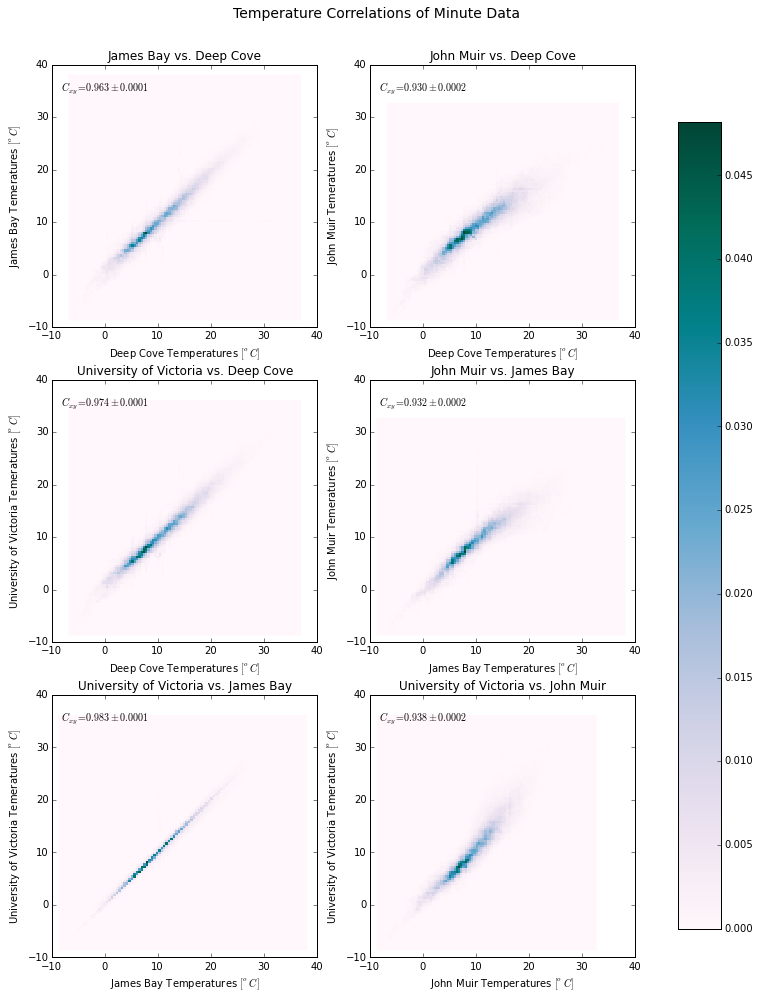

In [112]:
# Plot the correlations
def plotCorrelations(dc, jb, jm, uv):
    # Get the stats
    c_dc_jb = calcCorrelation(dc,jb)
    c_dc_jm = calcCorrelation(dc,jm)
    c_dc_uv = calcCorrelation(dc,uv)
    c_jb_jm = calcCorrelation(jb,jm)
    c_jb_uv = calcCorrelation(jb,uv)
    c_jm_uv = calcCorrelation(jm,uv)
    
    
    fig = plt.figure(figsize=(12,16))       # Make figure
    gs = gridspec.GridSpec(3,2)             # Set up the layout
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax4 = plt.subplot(gs[3])
    ax5 = plt.subplot(gs[4])
    ax6 = plt.subplot(gs[5])
    
    bins = 100
    cmap = cm.PuBuGn
    
    # Plot them
    (n,xx,yy,im) = ax1.hist2d(dc,jb,bins=bins,cmap=cmap,normed=True); ax1.set_xlabel(r'Deep Cove Temperatures $[^oC]$'); ax1.set_ylabel(r'James Bay Temeratures $[^oC]$'); ax1.set_title('James Bay vs. Deep Cove')
    ax2.hist2d(dc,jm,bins=bins,cmap=cmap,normed=True); ax2.set_xlabel(r'Deep Cove Temperatures $[^oC]$'); ax2.set_ylabel(r'John Muir Temeratures $[^oC]$'); ax2.set_title('John Muir vs. Deep Cove')
    ax3.hist2d(dc,uv,bins=bins,cmap=cmap,normed=True); ax3.set_xlabel(r'Deep Cove Temperatures $[^oC]$'); ax3.set_ylabel(r'University of Victoria Temeratures $[^oC]$'); ax3.set_title('University of Victoria vs. Deep Cove')
    ax4.hist2d(jb,jm,bins=bins,cmap=cmap,normed=True); ax4.set_xlabel(r'James Bay Temperatures $[^oC]$'); ax4.set_ylabel(r'John Muir Temeratures $[^oC]$'); ax4.set_title('John Muir vs. James Bay')
    ax5.hist2d(jb,uv,bins=bins,cmap=cmap,normed=True); ax5.set_xlabel(r'James Bay Temperatures $[^oC]$'); ax5.set_ylabel(r'University of Victoria Temeratures $[^oC]$'); ax5.set_title('University of Victoria vs. James Bay')
    ax6.hist2d(jm,uv,bins=bins,cmap=cmap,normed=True); ax6.set_xlabel(r'John Muir Temperatures $[^oC]$'); ax6.set_ylabel(r'University of Victoria Temeratures $[^oC]$'); ax6.set_title('University of Victoria vs. John Muir')
    
    # Add the labels
    ax1.annotate(r'$C_{xy} = %1.3f \pm %1.4f$' %c_dc_jb, xy=(0.,35.),  xycoords='data', xytext=(0., 35.), textcoords='data', horizontalalignment='center')
    ax2.annotate(r'$C_{xy} = %1.3f \pm %1.4f$' %c_dc_jm, xy=(0.,35.),  xycoords='data', xytext=(0., 35.), textcoords='data', horizontalalignment='center')
    ax3.annotate(r'$C_{xy} = %1.3f \pm %1.4f$' %c_dc_uv, xy=(0.,35.),  xycoords='data', xytext=(0., 35.), textcoords='data', horizontalalignment='center')
    ax4.annotate(r'$C_{xy} = %1.3f \pm %1.4f$' %c_jb_jm, xy=(0.,35.),  xycoords='data', xytext=(0., 35.), textcoords='data', horizontalalignment='center')
    ax5.annotate(r'$C_{xy} = %1.3f \pm %1.4f$' %c_jb_uv, xy=(0.,35.),  xycoords='data', xytext=(0., 35.), textcoords='data', horizontalalignment='center')
    ax6.annotate(r'$C_{xy} = %1.3f \pm %1.4f$' %c_jm_uv, xy=(0.,35.),  xycoords='data', xytext=(0., 35.), textcoords='data', horizontalalignment='center')
    
    # Add the title
    title = plt.suptitle('Temperature Correlations of Minute Data', fontsize=14)
    title.set_y(0.95)
    plt.subplots_adjust(top=0.90)
    
    # Give all plots the same scale
    ax1.set_ylim(bottom=-10,top=40);  ax1.set_xlim(left=-10,right=40)
    ax2.set_ylim(bottom=-10,top=40);  ax2.set_xlim(left=-10,right=40)
    ax3.set_ylim(bottom=-10,top=40);  ax3.set_xlim(left=-10,right=40)
    ax4.set_ylim(bottom=-10,top=40);  ax4.set_xlim(left=-10,right=40)
    ax5.set_ylim(bottom=-10,top=40);  ax5.set_xlim(left=-10,right=40)
    ax6.set_ylim(bottom=-10,top=40);  ax6.set_xlim(left=-10,right=40)
    
    # Add the color bar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    #fig.tight_layout()
    
# Estimate correlation coefficient
def calcCorrelation(a,b):
    a_minus_mean = a - np.mean(a)
    b_minus_mean = b - np.mean(b)
    N = len(a)
    
    # Coefficient
    sab = np.sum(a_minus_mean*b_minus_mean) / (N-1)
    sa = np.std(a,ddof=1)
    sb = np.std(b,ddof=1)
    corr = sab / sa / sb
    
    # Confidence Half Interval
    F = np.arctanh(corr)
    Fp95 = F+1.96/np.sqrt(N-3)
    Fm95 = F-1.96/np.sqrt(N-3)
    corr_p = np.tanh(Fp95)
    corr_m = np.tanh(Fm95)
    print 'p-corr=',corr_p-corr
    print 'corr-m=',corr-corr_m
    corr_halfwidth = corr_p-corr
    
    return corr, corr_halfwidth
    

plotCorrelations(dcminutedata, jbminutedata, jmminutedata, uvminutedata)

C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


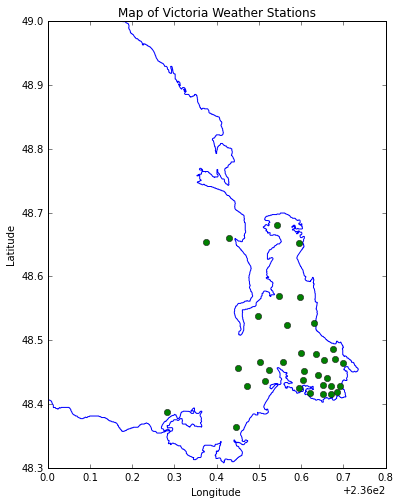

In [42]:
# Plot the stations
def plotMap(coastlongs,coastlats,schoollongs,schoollats):
    plt.figure(figsize=(12,8))        # Make figure
    gs=gridspec.GridSpec(1,1)         # Set up the layout
    ax = plt.subplot(gs[0])
    ax.plot(coastlongs,coastlats)
    ax.plot(schoollongs,schoollats,'o')
    ax.set_aspect(1./np.cos(48.5*np.pi/180))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Map of Victoria Weather Stations')
    
    return ax
    
plotMap(coastlongs,coastlats,schoollongs,schoollats)

In [43]:
# Create a mask for the coastline
def createMask():
    mask = np.genfromtxt('coastline_mask2.txt')  # array of 1's and nan's. switch values.
    mask[np.isnan(mask)] = 0.              
    mask[np.where(mask > 0.)] = np.nan
    mask[~np.isnan(mask)] = 1.
    return mask

mask = createMask()

C:\Anaconda\lib\site-packages\matplotlib\tri\triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


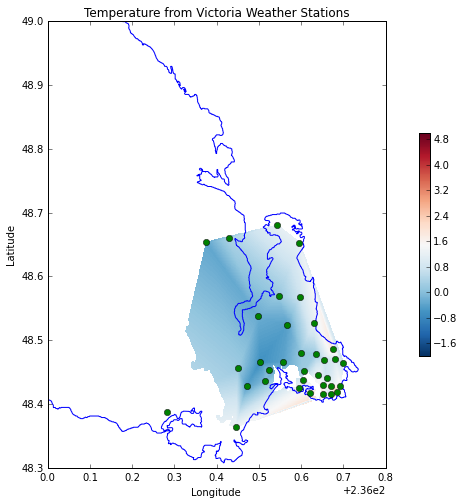

In [44]:
# Plot temperatures
def plotTemperatures(mask):

    # add temperatures to map
    firsthour = hourdata[:,20]
    x = schoollongs
    y = schoollats
    z = firsthour
    xi = np.linspace(np.min(coastlongs),np.max(coastlongs),1000)
    yi = np.linspace(np.min(coastlats),np.max(coastlats),1000)
    #xi = np.linspace(-123.2, -123.8, 1000)
    #yi = np.linspace(48.3, 48.7, 1000)
    gridx, gridy = np.meshgrid(xi, yi)
    
    # Apply the mask
    gridx = gridx*mask
    gridy = gridy*mask
    
    #print hourdata.shape

    #print len(x),len(y),len(firsthour)
    #zi = mlab.griddata(x,y,z,xi,yi,interp='linear')
    zi = mlab.griddata(x,y,z,xi,yi,interp='linear')

    ax = plotMap(coastlongs,coastlats,schoollongs,schoollats)
    ax.set_title('Temperature from Victoria Weather Stations')

    #pcm=ax.pcolormesh(xi,yi,np.ma.masked_invalid(zi),cmap='RdBu_r')
    pcm=ax.pcolormesh(gridx,gridy,np.ma.masked_invalid(zi),cmap='RdBu_r')
    #pcm.set_clim([np.min(firsthour),np.max(firsthour)])

    pcm.set_clim([-2.,5.])
    plt.colorbar(pcm,ax=ax,shrink=0.5)

    #print firsthour
    #print hourdata[:,0]
    
    
plotTemperatures(mask)

<module 'matplotlib.pyplot' from 'C:\Anaconda\lib\site-packages\matplotlib\pyplot.pyc'>

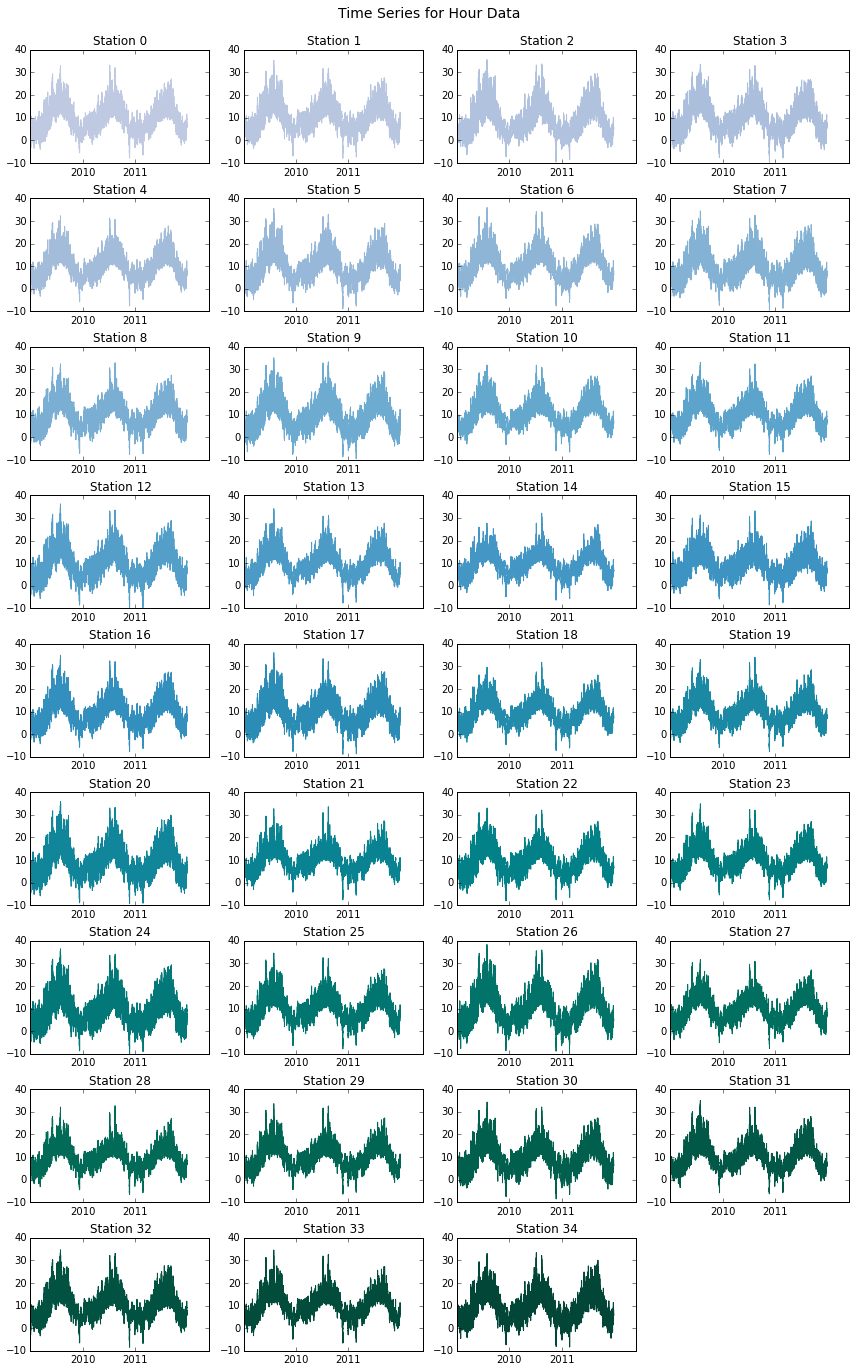

In [39]:
# Plot the time series data
def plotTimeSeries(labels, data):
    plt.figure(figsize=(12,20))       # Make figure
    gs=gridspec.GridSpec(9,4)        # Set up the layout
    
    
    
    one_year = 365*24 
    x = np.arange(len(labels))
    xticks = x[ one_year: :one_year ]
    xticklabels = labels[ one_year: :one_year ]
    for i,label in enumerate(xticklabels):
        xticklabels[i] = label[:4]
    
     
    
    # Plot the time series individually
    colors = cm.PuBuGn(np.linspace(0.3, 1, len(data)))
    for i in range(len(data)):
        ax = plt.subplot(gs[i])
        ax.plot(x, data[i], color=colors[i])
        ax.set_title('Station %d' %i)
        ax.set_xticks( xticks )
        ax.set_xticklabels( xticklabels )
        ax.set_ylim( bottom=-10, top=40 )
        
         
    title = plt.suptitle('Time Series for Hour Data', fontsize=14)
    plt.tight_layout()
    title.set_y(0.95)
    plt.subplots_adjust(top=0.92)
    return plt
    
    
    
plotTimeSeries(hours_as_strings, hourdata)

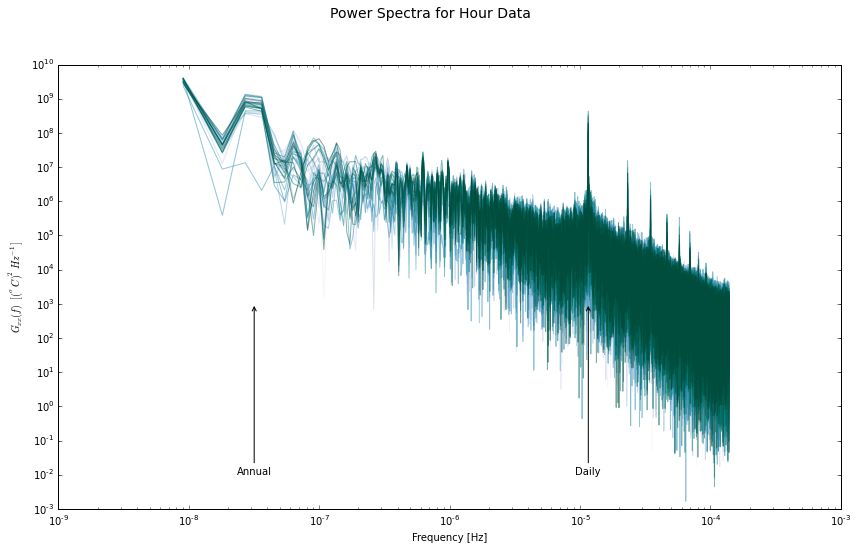

In [143]:
# Plot the power spectra
def plotPowerSpectra_hour(hourdata):
    plt.figure(figsize=(12,8))       # Make figure
    gs=gridspec.GridSpec(1,1)        # Set up the layout
    ax=plt.subplot(gs[0])            # select the cell to plot in
    
    dt = 3600.
    fs = 1./dt
    nfft = 1024*30
    #window = mlab.window_none
    window = mlab.window_hanning
    
    # Compute the power spectra
    spectra = []
    frequencies = []
    for station in hourdata:
        p,f=mlab.psd(station,NFFT=nfft,window=window,Fs=fs)
        spectra.append(p)
        frequencies.append(f)
    
    # plot the power spectra together
    colors = cm.PuBuGn(np.linspace(0, 1, len(spectra)))
    for i in range(len(spectra)):
        ax.loglog(frequencies[i],spectra[i],color=colors[i],alpha=0.5)

    # Set the axes
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r'$G_{xx}(f)\ \ [(^oC)^2 Hz^{-1}]$')
    
    # Label the important frequencies
    ax.annotate('Annual', xy=(1./3600/24/365, 1.e3),  xycoords='data',
                xytext=(1./3600/24/365, 1.e-2), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )
    ax.annotate('Daily', xy=(1./3600/24, 1.e3),  xycoords='data',
                xytext=(1./3600/24, 1.e-2), textcoords='data',
                horizontalalignment='center',
                arrowprops=dict(arrowstyle="->")
                )
    
    title = plt.suptitle('Power Spectra for Hour Data', fontsize=14)
    plt.tight_layout()
    title.set_y(0.95)
    plt.subplots_adjust(top=0.85)
    
plotPowerSpectra_hour(hourdata)

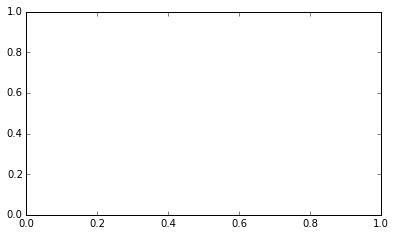

In [171]:
# Plot the EOFs
def calculateEOF(data):
    # Create covariance matrix
    covariance_matrix = np.cov(data.T)
    eigenvalues, eigenfunctions = np.linalg.eig(covariance_matrix)
    
    xe = np.dot(eigenfunctions.T,data)
    
    
    plt.figure(figsize=(14,8))       # Make figure
    gs=gridspec.GridSpec(2,2)        # Set up the layout
    ax=plt.subplot(gs[0])           # select the cell to plot in
    
    
    
    return ax
    
    
#calculateEOF(hourdata)

In [ ]:
# plot the strongest modes of variability
def plotModes(data):
    
    

plotModes(hourdata)

In [ ]:
# plot the time series of the modal amplitudes
def plotAmplitudes(data):



plotAmplitudes(hourdata)